# Cài đặt thư viện

In [ ]:
import unicodedata
import re
import numpy as np
from opencc import OpenCC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hàm xử lý tiếng Hán

In [ ]:
def normalize_chinese_text(text: str, to_traditional: bool = False) -> str:
      """
    Chuẩn hóa văn bản tiếng Trung bao gồm:
    - Chuẩn hóa Unicode
    - Chuyển đổi dấu câu và mã ký tự
    - Chuyển đổi giản thể ↔ phồn thể
    - Loại bỏ ký tự nhiễu (HTML, markdown, chú thích, ...)
    - Giữ lại ký tự CJK và dấu câu tiếng Trung phổ biến
    - Chuẩn hóa dấu câu lặp và định dạng ngoặc kép

    Args:
        text (str): Văn bản đầu vào cần chuẩn hóa
        to_traditional (bool):
            - True: chuyển văn bản về **phồn thể**
            - False (default): chuyển về **giản thể**

    Returns:
        str: Văn bản đã được chuẩn hóa

    Các bước xử lý cụ thể:
    1. Chuẩn hóa mã Unicode theo chuẩn NFKC
    2. Chuyển đổi ký tự full-width → half-width (dấu tiếng Trung thành ASCII)
    3. Chuyển đổi chữ Giản thể ↔ Phồn thể bằng OpenCC
    4. Xóa các yếu tố nhiễu như:
       - Thẻ HTML (`<...>`)
       - Chú thích dạng `[1]`, `【注】`
       - Markdown `#title`
    5. Giữ lại các ký tự tiếng Trung, khoảng trắng, và dấu câu chuẩn (`。，！？：「」『』—…·《》`)
    6. Chuẩn hóa khoảng trắng, loại bỏ dấu câu bị lặp
    7. Thay thế ngoặc kép tiếng Trung:
       - 「」 → “”
       - 『』 → “”
    """
  # 1. Normalize Unicode (NFKC)
    text = raw_text.replace(']', '」')
    text = unicodedata.normalize("NFKC", text)

    # 2. Convert full-width → half-width
    text = ''.join(
        chr(ord(c) - 0xFEE0) if 0xFF01 <= ord(c) <= 0xFF5E else c
        for c in text
    )

    # 3. Convert Simplified ↔ Traditional
    if to_traditional:
        text = OpenCC('s2t').convert(text)
    else:
        text = OpenCC('t2s').convert(text)

    # 4. Remove noise (HTML tags, markdown, [1], 【注】)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = re.sub(r'【[^】]*】', '', text)
    text = re.sub(r'#.*', '', text)
    text = text.replace(',', '，')
    # 5. Filter only CJK characters + standard punctuations
    text = ''.join(re.findall(r'[\u4e00-\u9fff\u3000-\u303f\uff00-\uffef。，、！? :「」『』—…·《》\s]+', text))

    # 6. Normalize spacing and repeated punctuation
    text = re.sub(r'\s+', '', text)  # Remove all whitespaces
    text = re.sub(r'([，。！? :「」『』—…·])\1+', r'\1', text)
    text = text.replace('「', '“').replace('」', '”')
    text = text.replace('『', '“').replace('』', '”')
    return text.strip()

def split_chinese_sentences(text):
    """
    Tách văn bản tiếng Hán thành từng câu hoàn chỉnh.

    Quy tắc tách:
    - Tách câu khi gặp dấu kết thúc câu: 。！？ (kèm hoặc không kèm dấu ngoặc kép ”)
    - Nếu dấu kết thúc là 。！？ rồi đến ” (ví dụ: ？”), thì tách sau dấu ”
    - Nếu chỉ là 。！？ và không có ” theo sau, thì tách ngay sau dấu đó
    - Không làm mất dấu câu hoặc dấu ngoặc kép
    - Câu phía sau sẽ được giữ nguyên nội dung

    Args:
        text (str): Văn bản tiếng Hán cần tách câu

    Returns:
        List[str]: Danh sách các câu đã tách, được loại bỏ khoảng trắng dư thừa

    Cách hoạt động:
    - Bước 1: Dùng re.sub() để chèn dấu phân cách đặc biệt (###) sau dấu kết câu
              với điều kiện: nếu sau dấu đó là ” → chèn sau ”
    - Bước 2: Với các dấu câu không có ” sau → chèn ngay sau dấu câu
    - Bước 3: Dùng .split('###') để phân chia văn bản thành các câu riêng biệt
    - Bước 4: Xoá khoảng trắng dư và lọc bỏ chuỗi rỗng
    """
    # Thêm dấu phân cách đặc biệt sau dấu kết thúc câu để tách
    text = re.sub(r'([。！?])”(?=\S)', r'\1”###', text)
    text = re.sub(r'([。！?])(?![”])(?=\S)', r'\1###', text)

    # Tách theo dấu ###
    sentences = text.split('###')

    return [s.strip() for s in sentences if s.strip()]

def analyze_and_export_sentences(sentences, csv_path='clustering_sentences.csv', plot_path='plots_sentences.png'):
        """
    Phân tích thống kê danh sách câu và xuất kết quả ra file CSV + biểu đồ histogram.

    Các bước thực hiện:
    1. Tính chiều dài từng câu (số ký tự)
    2. Tính thống kê mô tả: số lượng, trung bình, độ lệch chuẩn, min, max, phân vị 25%, 50%, 75%
    3. Phân loại các câu thành 3 nhóm độ dài:
       - "Ngắn": <= phân vị 25%
       - "Dài": >= phân vị 75%
       - "Trung bình": giữa Q1 và Q3
    4. Lưu bảng kết quả gồm: câu, độ dài, phân nhóm vào file CSV
    5. Vẽ và lưu biểu đồ histogram độ dài câu dưới dạng PNG

    Args:
        sentences (List[str]): Danh sách các câu đầu vào để phân tích
        csv_path (str): Đường dẫn lưu file CSV kết quả
        plot_path (str): Đường dẫn lưu file hình biểu đồ phân bố

    Returns:
        dict: Thống kê mô tả (mean, std, min, max, Q1, Q2, Q3, ...)
               hoặc thông báo lỗi nếu danh sách trống
    """
    lengths = [len(s) for s in sentences]

    if not lengths:
        print("Danh sách câu rỗng.")
        return

    # Thống kê
    q25, q50, q75 = np.percentile(lengths, [25, 50, 75])
    stats = {
        "Số lượng câu": len(sentences),
        "Chiều dài trung bình": round(np.mean(lengths), 2),
        "Độ lệch chuẩn": round(np.std(lengths), 2),
        "Chiều dài tối thiểu": min(lengths),
        "Chiều dài tối đa": max(lengths),
        "Phân vị 25%": q25,
        "Phân vị 50%": q50,
        "Phân vị 75%": q75
    }

    # Phân loại độ dài câu
    categories = []
    for l in lengths:
        if l <= q25:
            categories.append("Ngắn")
        elif l >= q75:
            categories.append("Dài")
        else:
            categories.append("Trung bình")

    # Lưu bảng kết quả
    df = pd.DataFrame({
        "Câu": sentences,
        "Độ dài": lengths,
        "Phân nhóm": categories
    })
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"Đã lưu bảng phân nhóm vào: {csv_path}")

    # Vẽ histogram
    plt.figure(figsize=(8, 4))
    plt.hist(lengths, bins=20, edgecolor='black')
    plt.title('Phân bố độ dài câu')
    plt.xlabel('Độ dài câu (số ký tự)')
    plt.ylabel('Số câu')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plot_path)
    print(f"Đã lưu biểu đồ vào: {plot_path}")

    return stats

stats = analyze_and_export_sentences(sentences)
print("\nThống kê:", stats)

# Main

✅ Đã lưu bảng phân nhóm vào: phan_nhom_cau.csv
✅ Đã lưu biểu đồ vào: do_dai_cau.png

Thống kê: {'Số lượng câu': 1221, 'Chiều dài trung bình': np.float64(21.85), 'Độ lệch chuẩn': np.float64(13.64), 'Chiều dài tối thiểu': 2, 'Chiều dài tối đa': 135, 'Phân vị 25%': np.float64(14.0), 'Phân vị 50%': np.float64(18.0), 'Phân vị 75%': np.float64(26.0)}


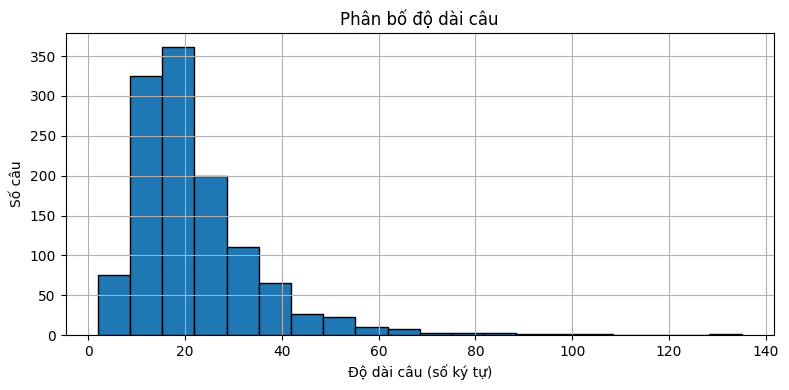

In [190]:
path = '/content/Book-Tay_Du_Ky-Trung_page_48_to_68.txt'
with open(path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
cleaned_text = normalize_chinese_text(raw_text)
sentences = split_chinese_sentences(cleaned_text)
# for i, s in enumerate(sentences, 1):
#     print(f"{i}. {s}")
stats = analyze_and_export_sentences(sentences)
print("\nThống kê:", stats)